In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [5]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [7]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [9]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Trend Following Signal

In [12]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [14]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [16]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [30]:
def get_average_true_range_portfolio(start_date, end_date, ticker_list, rolling_atr_window=20, price_or_returns_calc='price', use_coinbase_data=True):

    atr_list = []
    for ticker in ticker_list:
        atr_cols = [f'{ticker}_{rolling_atr_window}_avg_true_range_{price_or_returns_calc}']
        df_atr = size.calculate_average_true_range(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                   rolling_atr_window=rolling_atr_window, use_coinbase_data=use_coinbase_data)
        # df.at[date, atr_col] = df_atr.at[date, atr_col]
        atr_list.append(df_atr[atr_cols])

    df_atr_concat = pd.concat(atr_list, axis=1)

    # df = pd.merge(df, df_atr_concat, left_index=True, right_index=True, how='left')
    
    return df_atr_concat

In [38]:
# Below we calculate the number of risk units deployed per ticker per day
# Get Volatility Adjusted Trend Signal for Target Volatility Strategy
def get_volatility_adjusted_trend_signal_continuous(df, ticker_list, volatility_window, annual_trading_days=365):
    
    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        trend_signal_col = f'{ticker}_final_signal'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'

        ## Calculate Position Volatility Adjusted Trend Signal
        df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
        df = tf.get_returns_volatility(df, vol_range_list=[volatility_window], close_px_col=f'{ticker}_t_1_close')
        df[annualized_volatility_col] = (df[f'{ticker}_t_1_close_volatility_{volatility_window}'] *
                                         np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        trend_cols = [f'{ticker}_close', f'{ticker}_open', f'{ticker}_t_1_close', f'{ticker}_t_1_close_pct_returns',
                      trend_signal_col, final_weighted_additive_signal_col, annualized_volatility_col,
                      vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    return df_signal

In [24]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                           donchian_signal_weight, ma_crossover_signal_weight,
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )

    ## Calculate Trend Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left') 

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

In [157]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_adx(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                                    donchian_signal_weight, ma_crossover_signal_weight,
                                                                    moving_avg_type='exponential', price_or_returns_calc='price',
                                                                    long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )

    ## Calculate Trend Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Add ADX Signal
    adx_period = 14
    adx_signal_threshold = 25
    adx_floor = 10
    adx_cap = 45
    strength_factor_col = f'{ticker}_adx_strength_factor'
    df_adx = calculate_average_directional_index(start_date, end_date, ticker=ticker, adx_period=adx_period)
    df_trend = pd.merge(df_trend, df_adx, left_index=True, right_index=True, how='left')
    # df_trend[f'{ticker}_adx_scaler'] = np.clip(df_trend[f'{ticker}_avg_dir_ind'] / 50.0, 0.0, 1.0)
    df_trend[f'{ticker}_adx_scaler'] = np.clip((df_trend[f'{ticker}_avg_dir_ind'] - adx_floor) / (adx_cap - adx_floor), 0.0, 1.0)
    # df_trend[strength_factor_col] = np.where(df_trend[f'{ticker}_avg_dir_ind'] > adx_signal_threshold, df_trend[f'{ticker}_adx_scaler'], 0)
    df_trend[strength_factor_col] = df_trend[f'{ticker}_adx_scaler']    

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col]) * df_trend[strength_factor_col]

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    # k = 1
    # Dead Band under abs(0.03)
    # dead_band_cond = (np.abs(df_trend[final_weighted_additive_signal_col]) < 0.03)
    # df_trend.loc[dead_band_cond, final_weighted_additive_signal_col] = 0
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend


def get_trend_donchian_signal_for_portfolio_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_threshold, donchian_threshold, final_weighted_additive_signal_threshold,
                                                  final_weighted_multiplicative_signal_threshold,
                                                  rolling_donchian_window, donchian_signal_weight, ma_crossover_signal_weight,
                                                  long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:

        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_adx(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_adx(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight, 
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
            
        trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
                      trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [159]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                mavg_stepsize, ma_crossover_signal_weight, rolling_donchian_window, donchian_signal_weight, long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, rolling_sharpe_window=50,
                                                                cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_macro(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                             slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_threshold=mavg_z_score_threshold, donchian_threshold=donchian_threshold, 
                                                             final_weighted_additive_signal_threshold=final_weighted_additive_signal_threshold,
                                                             final_weighted_multiplicative_signal_threshold=final_weighted_multiplicative_signal_threshold,
                                                             donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                             rolling_donchian_window=rolling_donchian_window, long_only=long_only, use_coinbase_data=use_coinbase_data)
    
    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                              price_or_returns_calc='price', use_coinbase_data=True)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                          rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                          transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## Testing Signal

In [50]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']#,'ETH-USD','SOL-USD']#,'DOGE-USD','LTC-USD','CRO-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 0.5
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.8
donchian_signal_weight = 0.2

In [52]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
df_final_with_smoothing_and_stretching_act = apply_target_volatility_position_sizing_continuous_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                                                                         mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                                                                                                         donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
                                                                                                         initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                                                                                                         rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                                                                                                         transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                                                                         rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                                                                                                         annualized_target_volatility=annualized_target_volatility,
                                                                                                         annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [73]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## ADX Cap = 45
## ADX Floor = 12
df_final_with_smoothing_and_stretching_act_with_adx = apply_target_volatility_position_sizing_continuous_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                                                                         mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                                                                                                         donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
                                                                                                         initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                                                                                                         rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                                                                                                         transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                                                                         rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                                                                                                         annualized_target_volatility=annualized_target_volatility,
                                                                                                         annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [147]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## ADX Cap = 50
## ADX Floor = 15
df_final_with_smoothing_and_stretching_act_with_adx_15_50 = apply_target_volatility_position_sizing_continuous_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                                                                         mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                                                                                                         donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
                                                                                                         initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                                                                                                         rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                                                                                                         transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                                                                         rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                                                                                                         annualized_target_volatility=annualized_target_volatility,
                                                                                                         annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [161]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## ADX Cap = 45
## ADX Floor = 10
df_final_with_smoothing_and_stretching_act_with_adx_10_45 = apply_target_volatility_position_sizing_continuous_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                                                                         mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                                                                                                         donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
                                                                                                         initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                                                                                                         rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                                                                                                         transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                                                                         rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                                                                                                         annualized_target_volatility=annualized_target_volatility,
                                                                                                         annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [53]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6132442325590381,
 'annualized_sharpe_ratio': 1.471596551452189,
 'calmar_ratio': 1.9579628921180163,
 'annualized_std_dev': 0.6684669647922363,
 'max_drawdown': -0.3132052374576233,
 'max_drawdown_duration': Timedelta('519 days 00:00:00'),
 'hit_rate': 0.20229612034837688,
 't_statistic': 4.263509287626183,
 'p_value': 2.0863392843466507e-05,
 'trade_count': 465.0}

In [74]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## ADX Cap = 45
## ADX Floor = 12
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.607641710604675,
 'annualized_sharpe_ratio': 1.4607622293524385,
 'calmar_ratio': 1.9400751901120055,
 'annualized_std_dev': 0.6671817757303821,
 'max_drawdown': -0.31320523745762363,
 'max_drawdown_duration': Timedelta('519 days 00:00:00'),
 'hit_rate': 0.20190023752969122,
 't_statistic': 4.234941592928816,
 'p_value': 2.3679395747018928e-05,
 'trade_count': 467.0}

In [148]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## ADX Cap = 50
## ADX Floor = 15
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_50, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5526433109397402,
 'annualized_sharpe_ratio': 1.359796408782878,
 'calmar_ratio': 1.8689005079824503,
 'annualized_std_dev': 0.6653103812168976,
 'max_drawdown': -0.29570504613771004,
 'max_drawdown_duration': Timedelta('519 days 00:00:00'),
 'hit_rate': 0.19319081551860648,
 't_statistic': 3.971430700881284,
 'p_value': 7.343983828437566e-05,
 'trade_count': 466.0}

In [162]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## ADX Cap = 45
## ADX Floor = 10
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_10_45, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6132442325590381,
 'annualized_sharpe_ratio': 1.4715965514521885,
 'calmar_ratio': 1.9579628921180132,
 'annualized_std_dev': 0.6684669647922364,
 'max_drawdown': -0.3132052374576238,
 'max_drawdown_duration': Timedelta('519 days 00:00:00'),
 'hit_rate': 0.20229612034837688,
 't_statistic': 4.263509287626184,
 'p_value': 2.086339284346639e-05,
 'trade_count': 465.0}

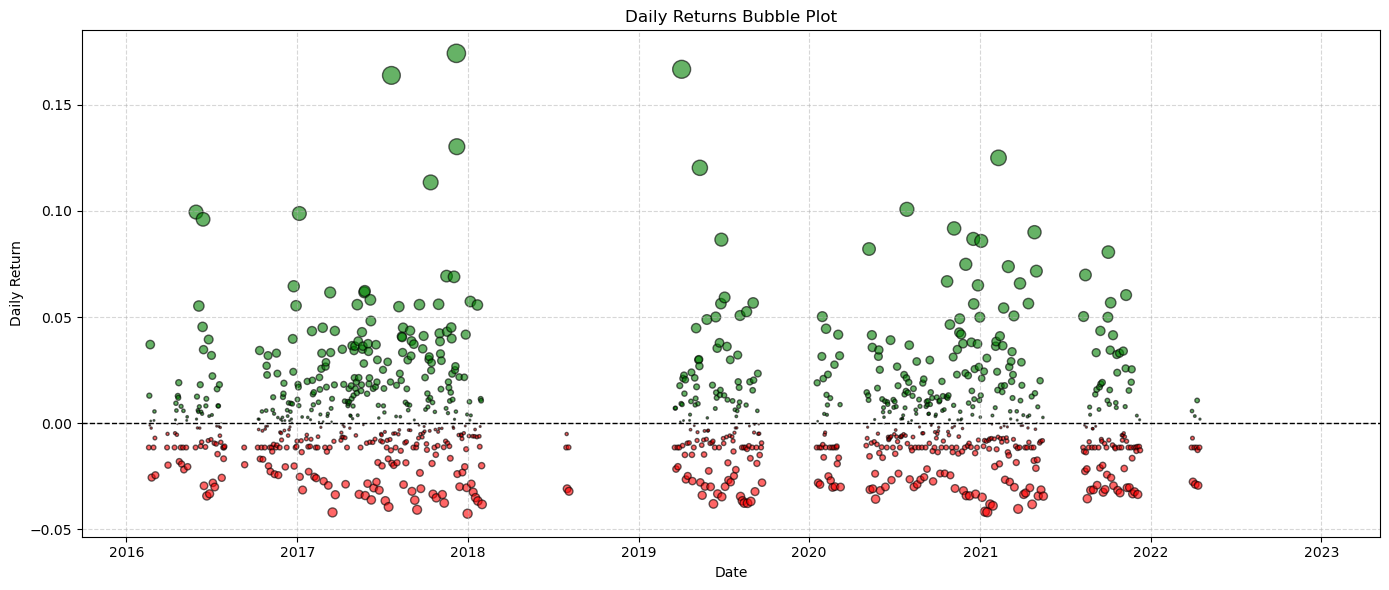

In [75]:
perf.plot_daily_returns_bubble(df_final_with_smoothing_and_stretching_act_with_adx, return_col='portfolio_daily_pct_returns')

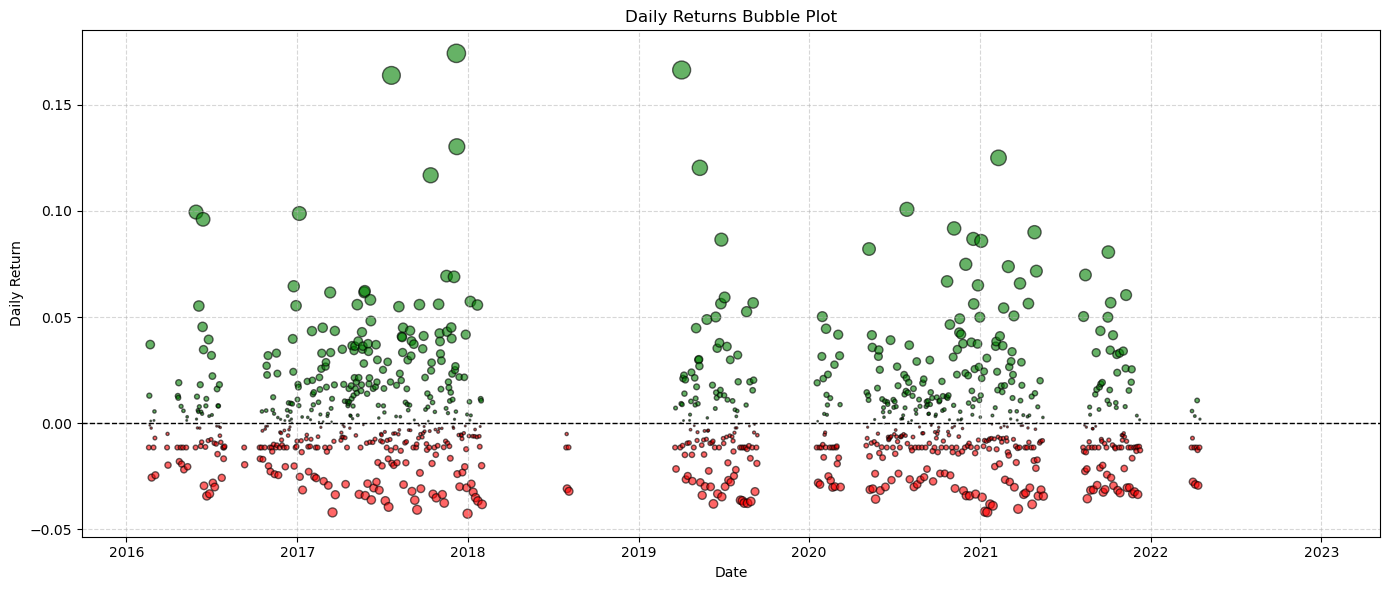

In [149]:
perf.plot_daily_returns_bubble(df_final_with_smoothing_and_stretching_act_with_adx_15_50, return_col='portfolio_daily_pct_returns')

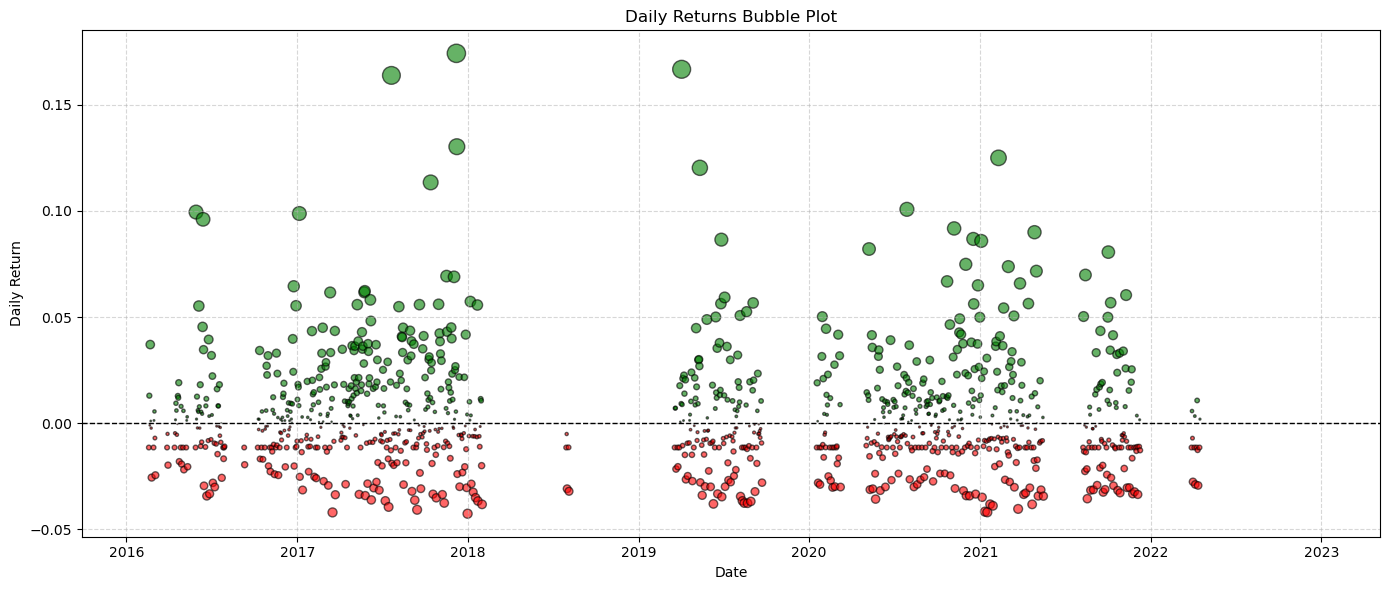

In [165]:
perf.plot_daily_returns_bubble(df_final_with_smoothing_and_stretching_act_with_adx_10_45, return_col='portfolio_daily_pct_returns')

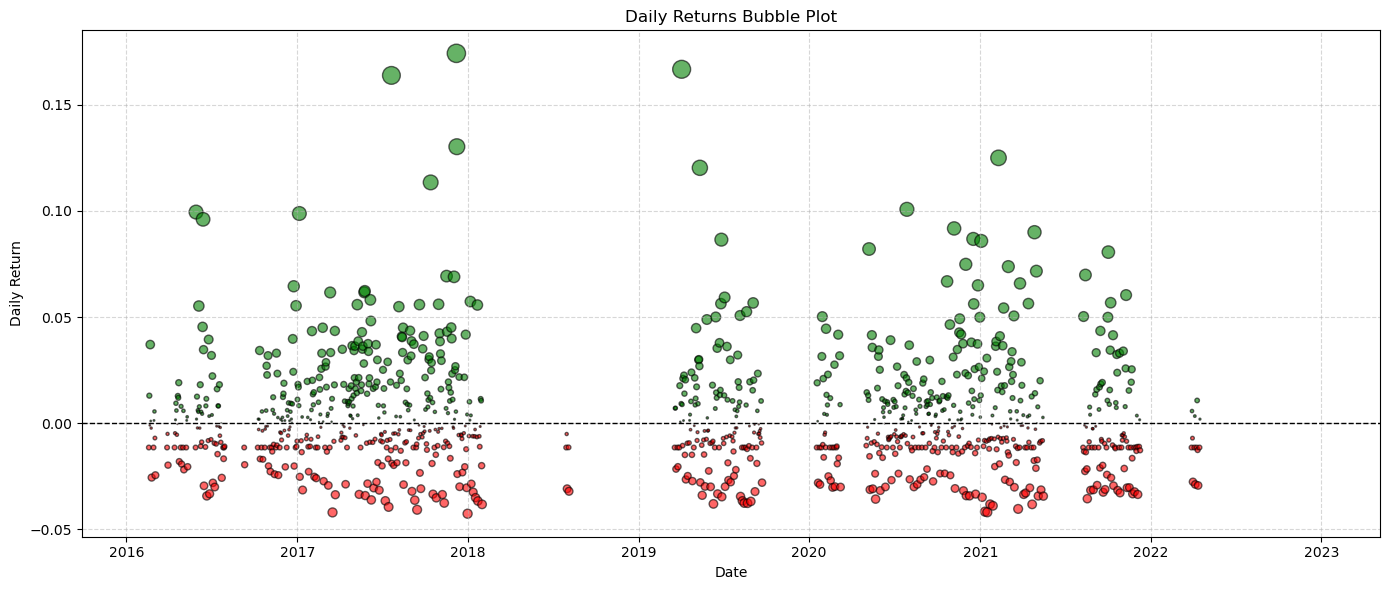

In [56]:
perf.plot_daily_returns_bubble(df_final_with_smoothing_and_stretching_act, return_col='portfolio_daily_pct_returns')

In [137]:
def plot_signal_performance(df_1, df_2, ticker):
    
    fig = plt.figure(figsize=(15,8))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel('Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()


    plt.tight_layout()
    
    return

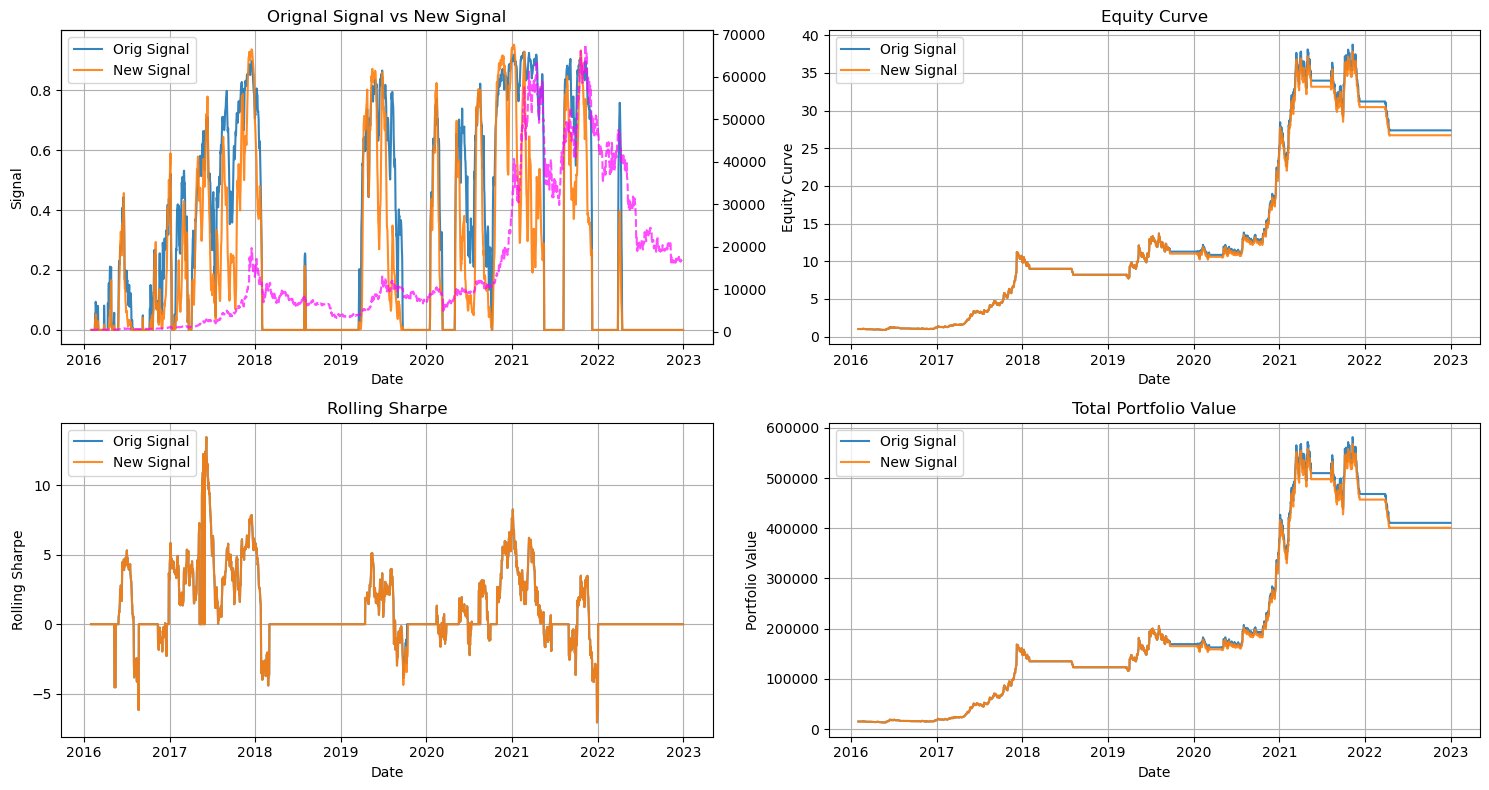

In [139]:
plot_signal_performance(df_final_with_smoothing_and_stretching_act, df_final_with_smoothing_and_stretching_act_with_adx, ticker='BTC-USD')

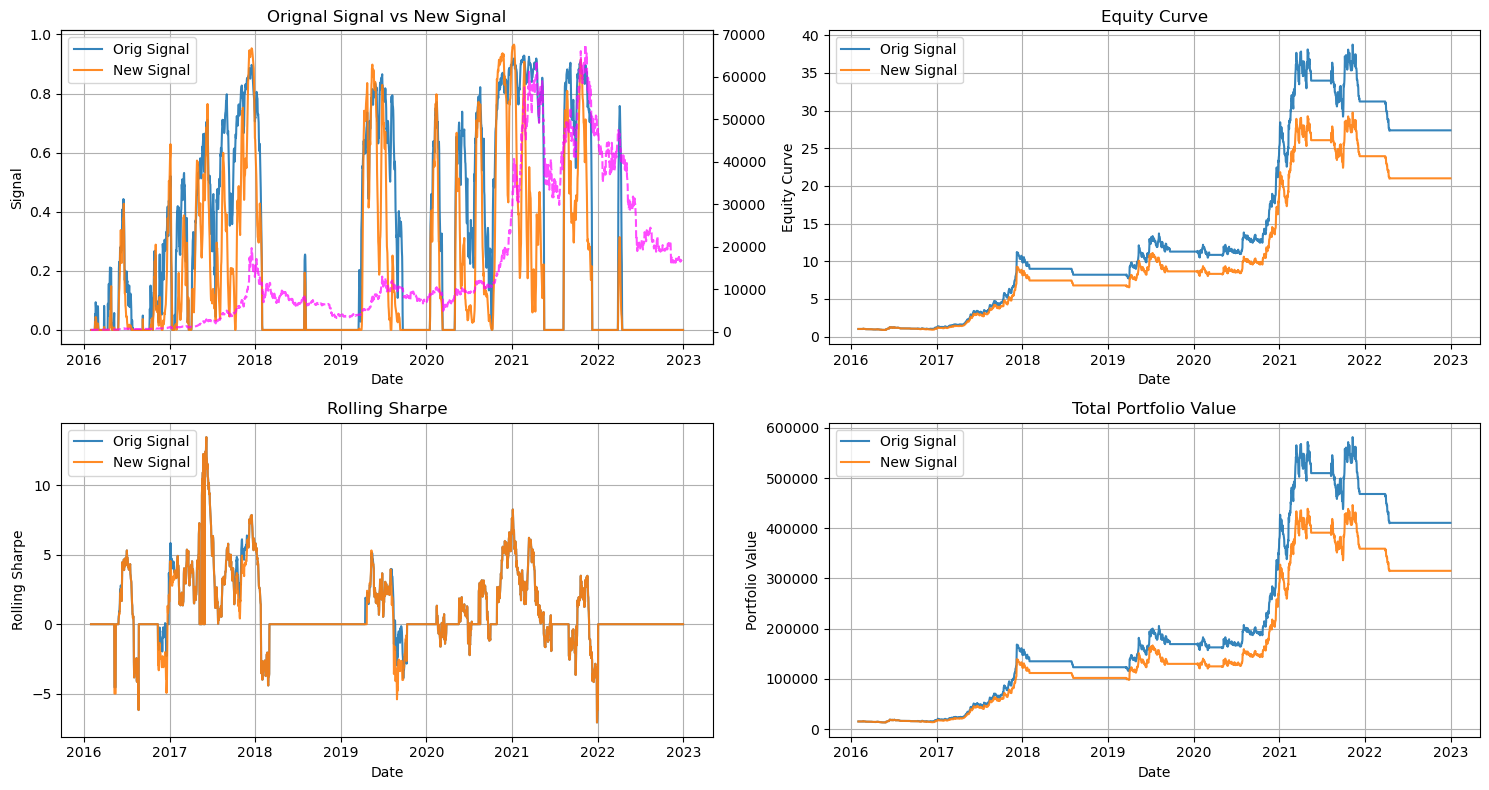

In [155]:
plot_signal_performance(df_final_with_smoothing_and_stretching_act, df_final_with_smoothing_and_stretching_act_with_adx_15_50, ticker='BTC-USD')

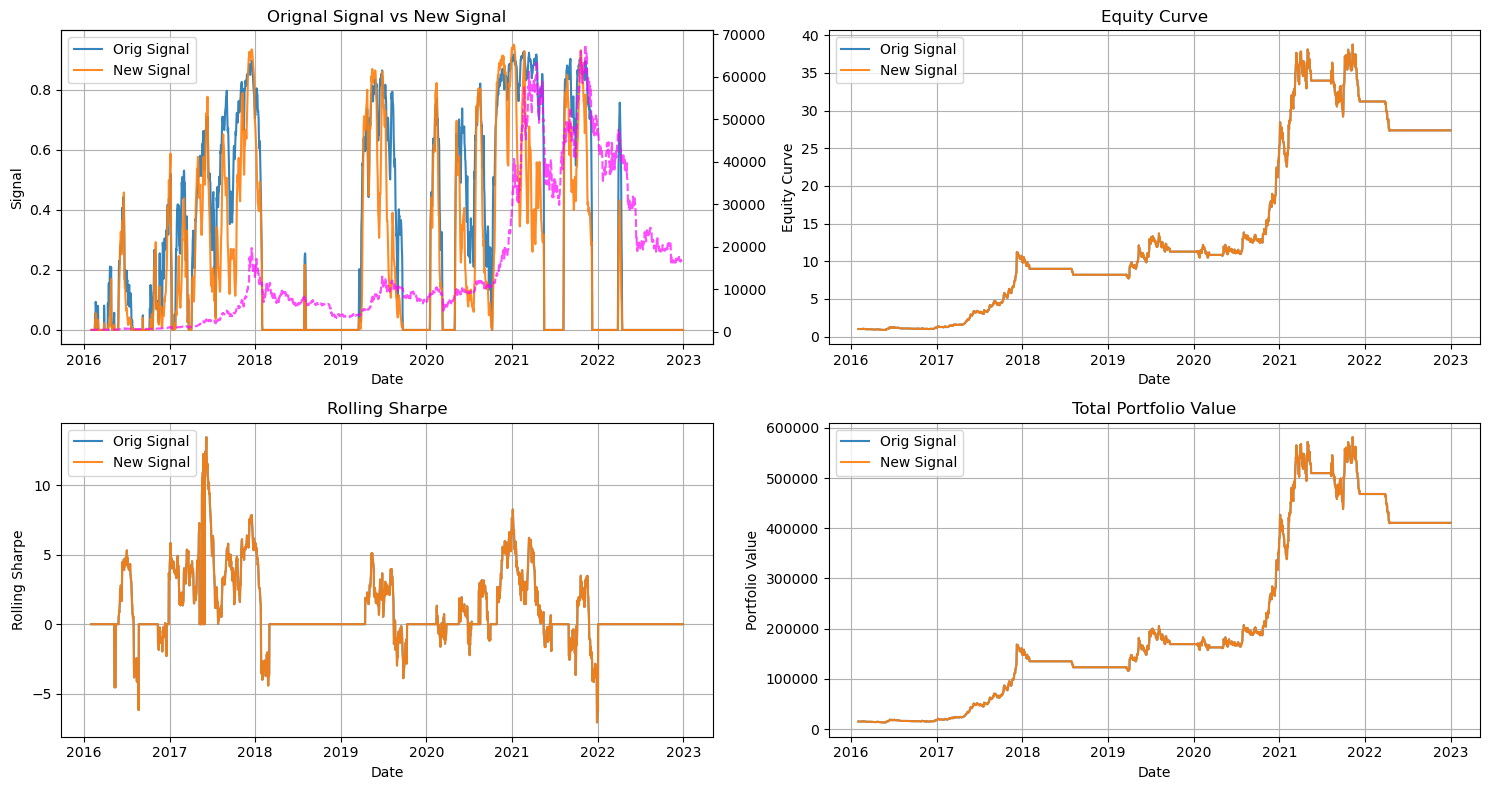

In [167]:
plot_signal_performance(df_final_with_smoothing_and_stretching_act, df_final_with_smoothing_and_stretching_act_with_adx_10_45, ticker='BTC-USD')